In [1]:
import matplotlib.pyplot as plt
import anndata as adata
import scanpy as sc
from wmb import cemba, mm10
from ALLCools.mcds import MCDS
from ALLCools.clustering import significant_pc_test
from ALLCools.plot import *
import pandas as pd
from harmonypy import run_harmony

In [2]:
df_annoatation = pd.read_csv('output/df_PFC_annotation.csv',index_col=0)

In [3]:
df_celltype = df_annoatation[['celltype.L1',
       'Neurotransmitter', 'Neurotransmitter_celltype', 'celltype.L2','rowname']]

In [4]:
df_celltype.set_index('rowname',inplace=True)

In [5]:
df_celltype.head()

,celltype.L1,Neurotransmitter,Neurotransmitter_celltype,celltype.L2
rowname,,,,
AAACCCAAGCTAGCCC-1-0-0-1,Neuron,NaN,GABAergic,Pvalb GABA
AAACCCAAGCTGGAGT-1-0-0-1,Neuron,NaN,Glutamatergic,L2/3 IT
AAACCCAAGGATACCG-1-0-0-1,Neuron,NaN,Glutamatergic,L6 IT
AAACCCAAGGGTCACA-1-0-0-1,Neuron,NaN,Glutamatergic,L6 CT
AAACCCAAGTGCTAGG-1-0-0-1,Neuron,NaN,Glutamatergic,L4/5 IT


In [11]:
adata_concat = sc.read_h5ad('/data2st1/junyi/output/merged-harmony-clustering.h5ad')


In [12]:
adata_concat

AnnData object with n_obs × n_vars = 41148 × 1059
    obs: 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'doublet_score', 'predicted_doublet', 'batch', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'pred_dmb', 'pred_mwb', 'pred_mdg', 'pred_mih', 'pred_mpd', 'sampleID', 'tech', 'louvain', 'pred_Class', 'cell', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'CellGroup', 'SubClass', 'Class', 'NeuroTransmitters', 'mc_all_tsne_0', 'mc_all_tsne_1', 'mc_all_umap_0', 'mc_all_umap_1', 'mr_tsne_0', 'mr_tsne_1', 'mr_tsne_0.1', 'mr_tsne_1.1', 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mi

In [24]:
adata_concat.obs['batch']

AAACCCAAGCTAGCCC-1-0-0-1-0      sc
AAACCCAAGCTGGAGT-1-0-0-1-0      sc
AAACCCAAGGATACCG-1-0-0-1-0      sc
AAACCCAAGGGTCACA-1-0-0-1-0      sc
AAACCCAAGTGCTAGG-1-0-0-1-0      sc
                              ... 
WT_TTTGTGTTCACGTCAA-1-3       atac
WT_TTTGTGTTCCAACAAC-1-3       atac
WT_TTTGTGTTCCGTACGG-1-3       atac
WT_TTTGTGTTCCTGACCT-1-3       atac
WT_TTTGTGTTCTGACTTT-1-3       atac
Name: batch, Length: 41148, dtype: category
Categories (4, object): ['sc', 'mcg', 'mch', 'atac']

In [27]:
df_celltype.index = df_celltype.index+'-0'

In [28]:
adata_concat.obs = adata_concat.obs.merge(df_celltype,left_index=True,right_index=True,how='left')

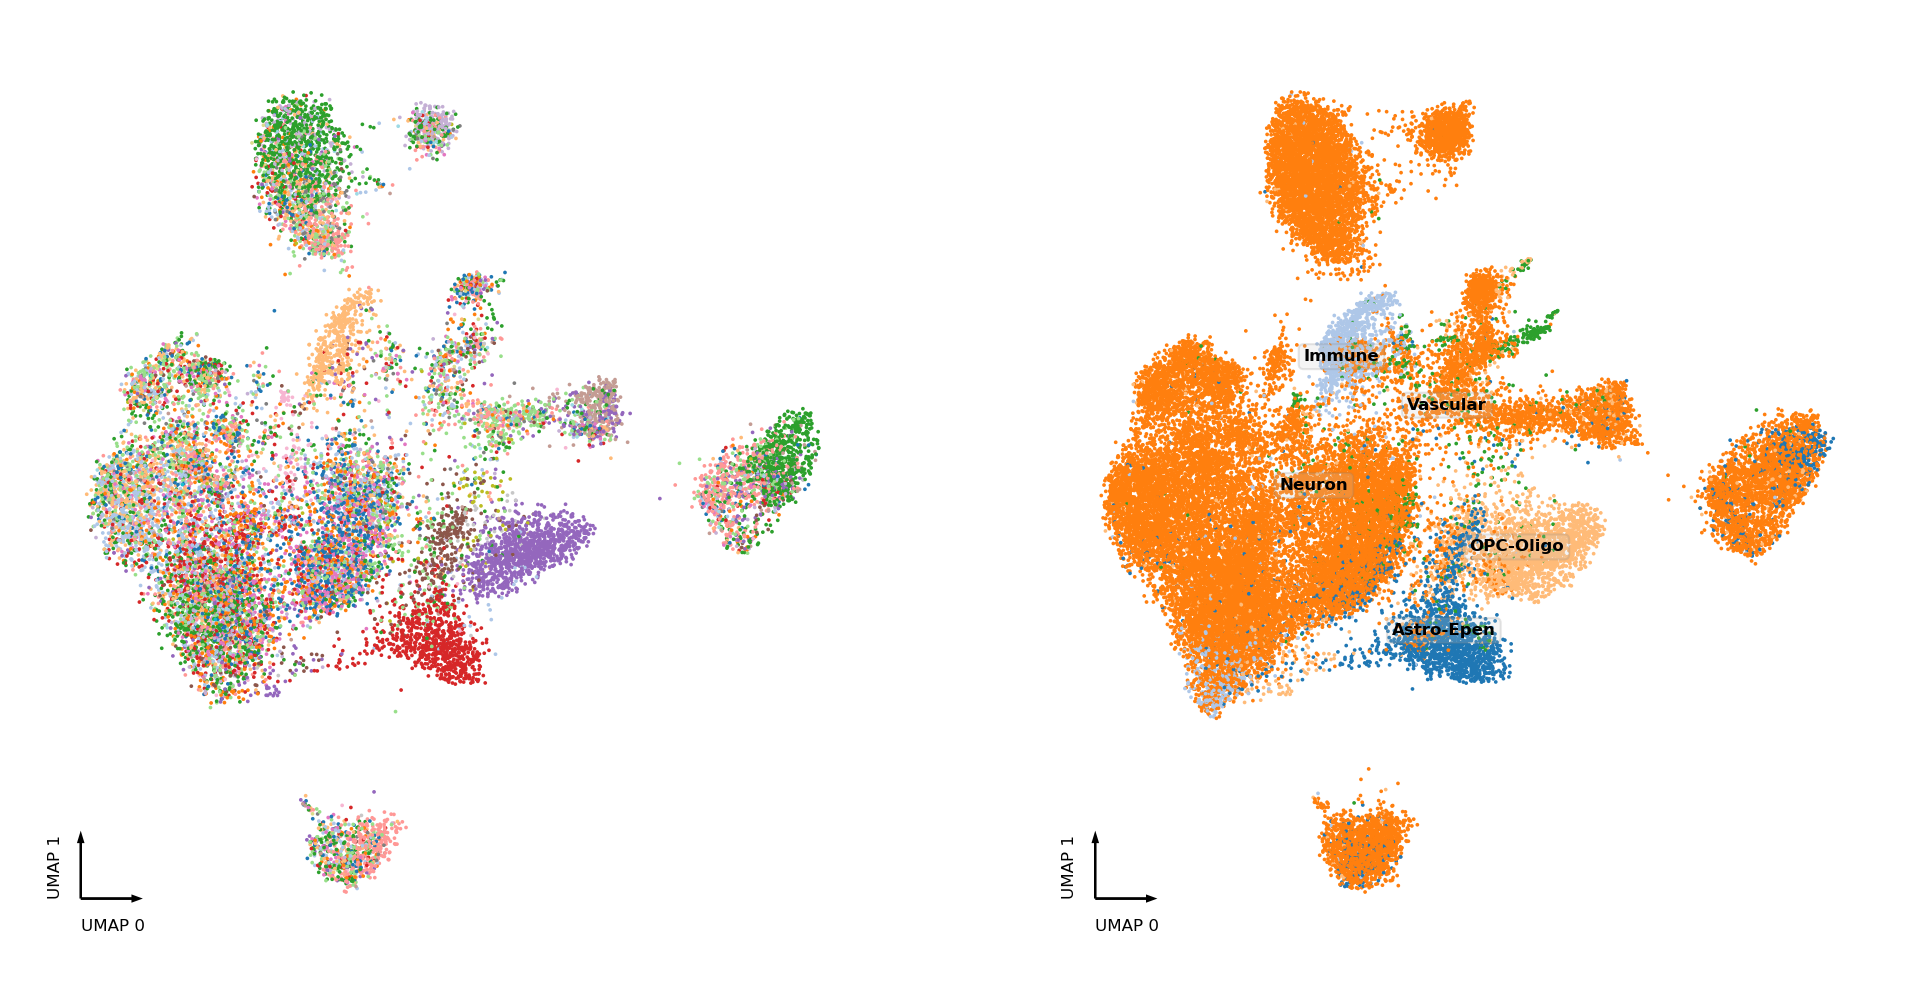

In [170]:
fig, axes = plt.subplots(figsize=(8, 4), dpi=300, ncols=2)
ax = axes[0]
categorical_scatter(ax=ax, data=adata_concat, hue='louvain', palette='tab20')
ax = axes[1]
categorical_scatter(ax=ax, data=adata_concat, hue='celltype.L1', palette='tab20',text_anno='celltype.L1')

In [171]:
adata_sc_train = adata_concat[adata_concat.obs['batch'] == 'sc']

In [172]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
y_train = adata_sc_train.obs['celltype.L2']
le = LabelEncoder()
y_train = le.fit_transform(y_train)
X_train = adata_sc_train.obsm['X_pca']

In [173]:
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [174]:
adata_sc_test = adata_concat[adata_concat.obs['batch'] != 'sc']
X_test = adata_sc_test.obsm['X_pca']
y_test = clf.predict(X_test)

In [175]:
y_test = le.inverse_transform(y_test)

In [176]:
adata_sc_test.obs['predicted_celltype'] = y_test

/tmp/ipykernel_229475/1270472714.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc_test.obs['predicted_celltype'] = y_test


/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


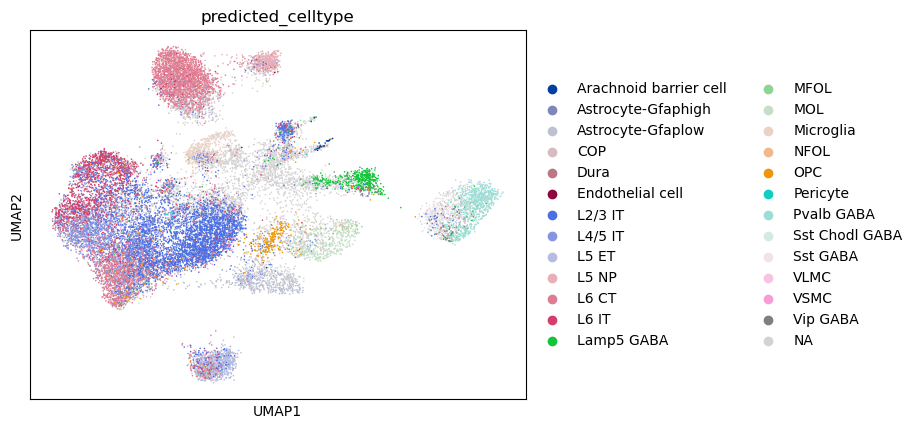

In [177]:
sc.pl.umap(adata_sc_test, color=['predicted_celltype'], ncols=2)

In [178]:
adata_concat.obs['celltype.L2.p'] = adata_concat.obs['celltype.L2']

In [179]:
adata_concat.obs.loc[adata_sc_test.obs.index,'celltype.L2']=y_test

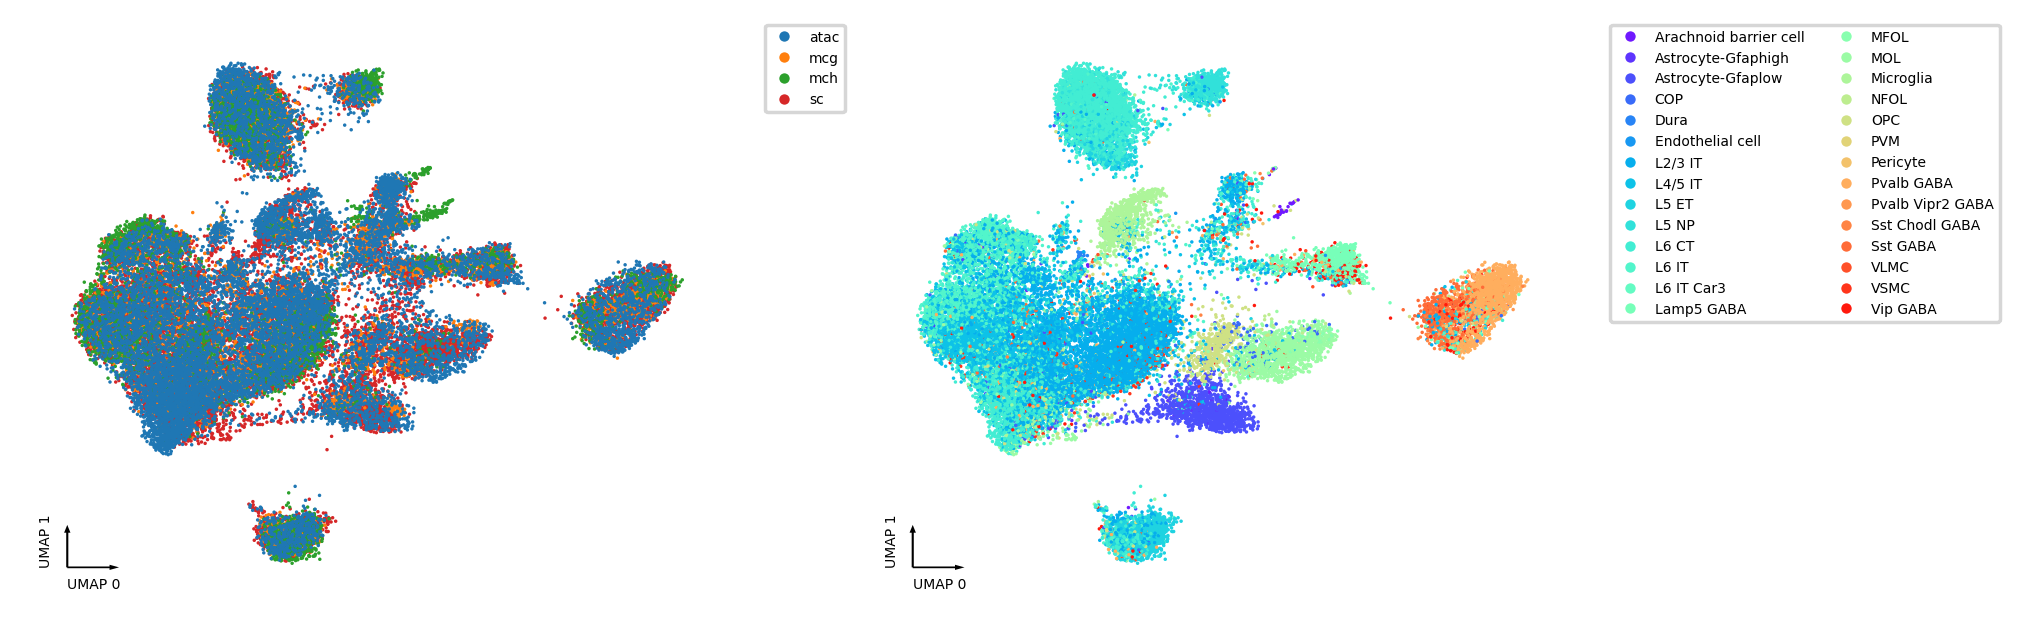

In [180]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

ax = axes[0]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='batch',
                    show_legend=True,
                    max_points=None,
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='celltype.L2',
                    show_legend=True,
                    max_points=None,
                    s=1)

In [181]:
y_train = adata_sc_train.obs['celltype.L1']
le = LabelEncoder()
y_train = le.fit_transform(y_train)
clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [182]:
y_test = clf.predict(X_test)
y_test = le.inverse_transform(y_test)
adata_sc_test.obs['predicted_celltype'] = y_test

In [183]:
adata_concat.obs['celltype.L1.p'] = adata_concat.obs['celltype.L1']

In [184]:
adata_concat.obs.loc[adata_sc_test.obs.index,'celltype.L1']=y_test

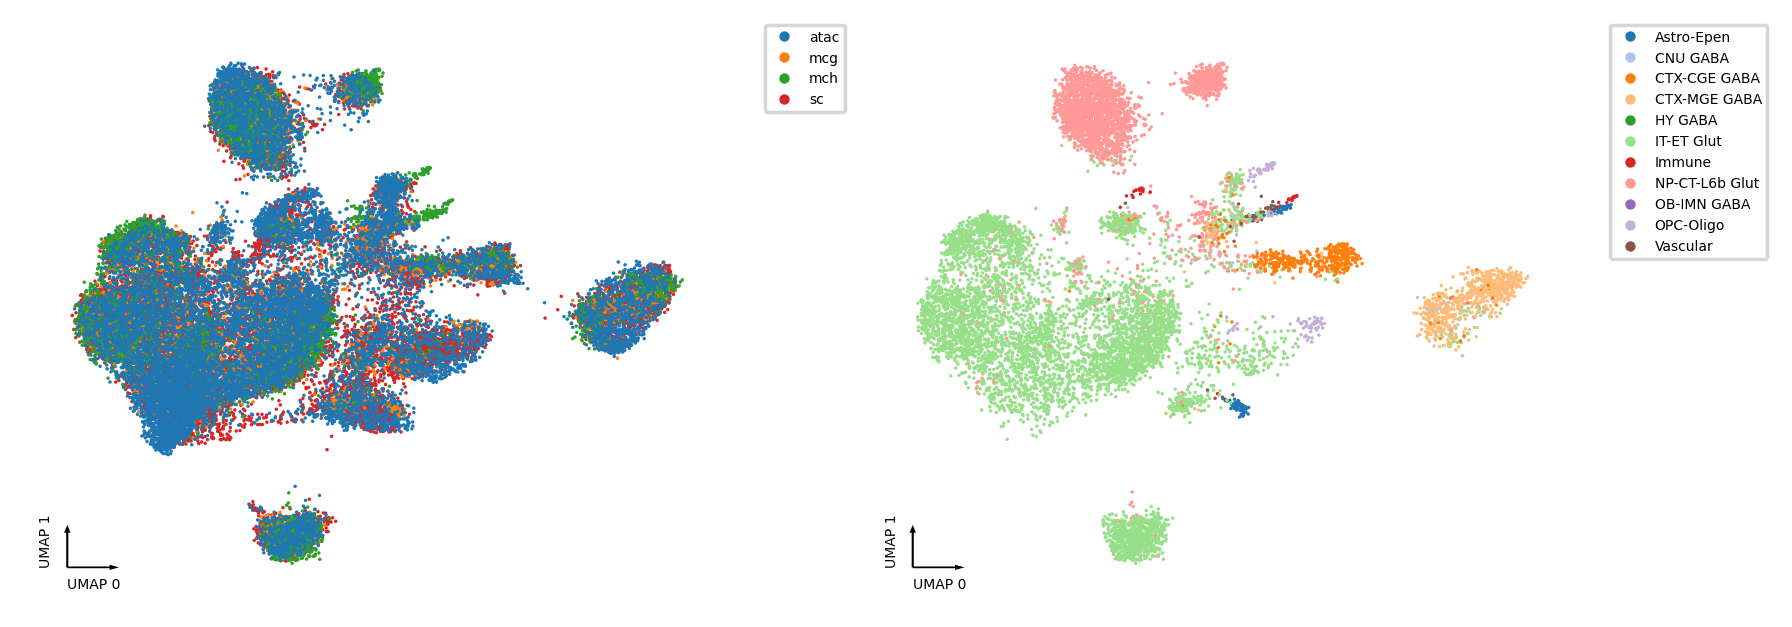

In [185]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

ax = axes[0]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='batch',
                    show_legend=True,
                    max_points=None,
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='Class',
                    show_legend=True,
                    max_points=None,
                    s=1)

In [186]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return


In [187]:
dump_embedding(adata_concat, 'umap')


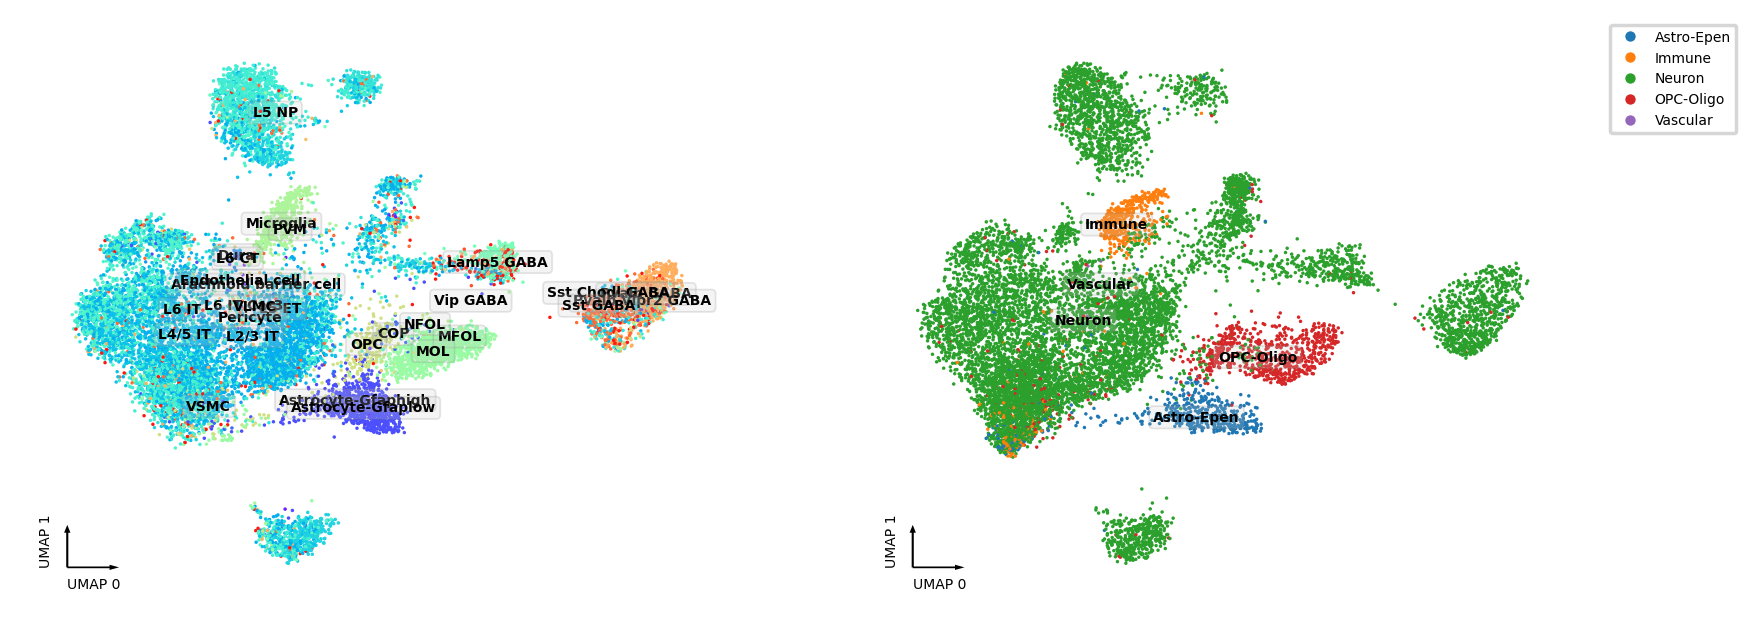

In [191]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

data = adata_concat.obs[adata_concat.obs['batch'] == 'sc'].copy()
#data['MajorType'] = data['SubType'].str.split('_').str[-1]
data2 = adata_concat.obs[adata_concat.obs['batch'] == 'atac'].copy()


ax = axes[0]
categorical_scatter(ax=ax,
                    data=data,
                    show_legend=False,
                    max_points=None,
                    hue='celltype.L2',
                    text_anno='celltype.L2',
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=data2,
                    hue='celltype.L1',
                    show_legend=True,
                    text_anno='celltype.L1',

                    max_points=None,
                    s=1)

In [189]:
data2.columns

Index(['sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'doublet_score', 'predicted_doublet',
       'batch', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'pred_dmb',
       'pred_mwb', 'pred_mdg', 'pred_mih', 'pred_mpd', 'sampleID', 'tech',
       'louvain', 'pred_Class', 'cell', 'mCCCFrac', 'mCGFrac', 'mCHFrac',
       'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384',
       'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC',
       'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'CellGroup',
       'SubClass', 'Class', 'NeuroTransmitters', 'mc_all_tsne_0',
       'mc_all_tsne_1', 'mc_all_umap_0', 'mc_all_umap_1', 'mr_tsne_0',
       'mr_tsne_1', 'mr_tsne_0.1', 'mr_tsne_1.1', 'orig.ident', 'nCount_peaks',
       'nFeature_peaks', 'total', 'duplicate',

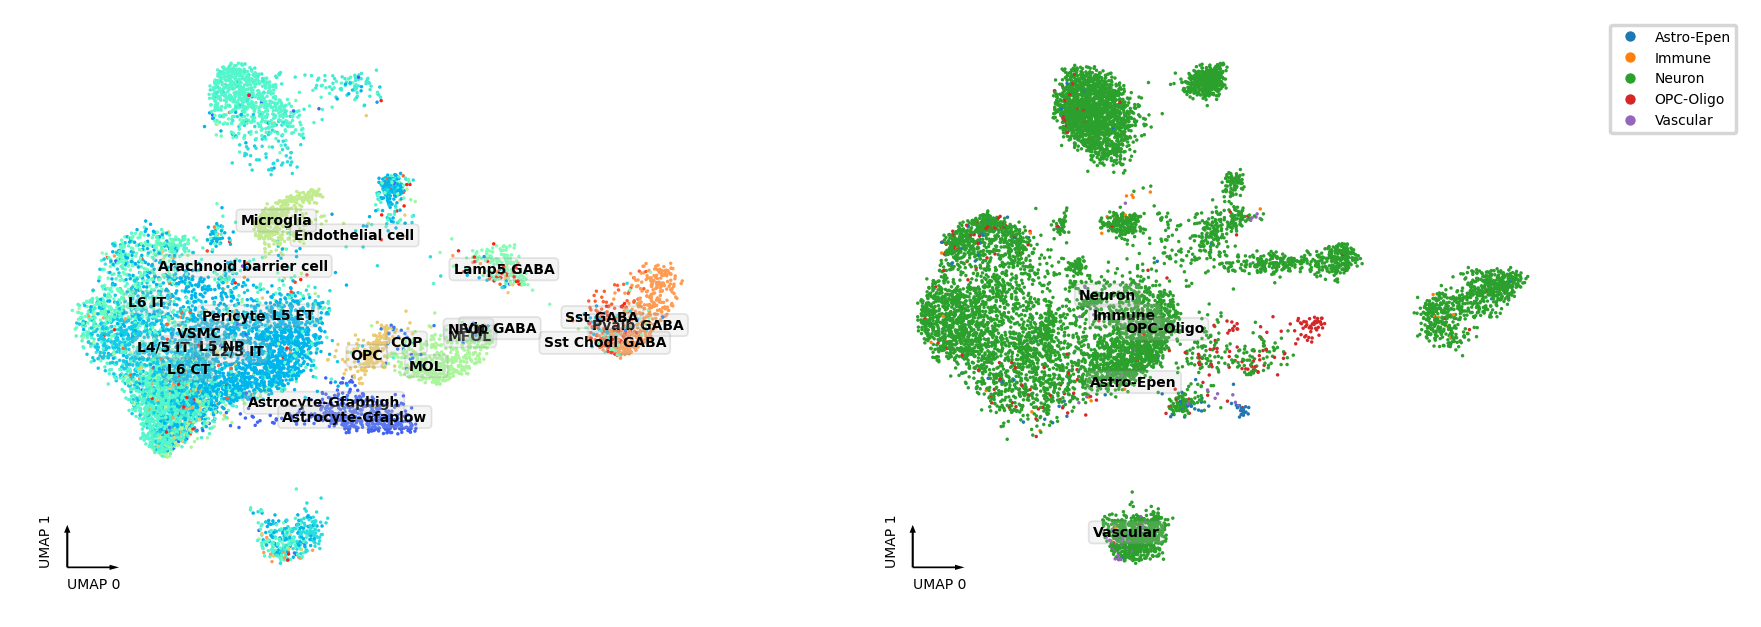

In [ ]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

data = adata_concat.obs[adata_concat.obs['batch'] == 'atac'].copy()
#data['MajorType'] = data['SubType'].str.split('_').str[-1]
data2 = adata_concat.obs[adata_concat.obs['batch'].isin(['mcg','mch'])].copy()


ax = axes[0]
categorical_scatter(ax=ax,
                    data=data,
                    show_legend=False,
                    max_points=None,
                    hue='celltype.L2',
                    text_anno='celltype.L2',
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=data2,
                    hue='celltype.L1',
                    show_legend=True,
                    text_anno='celltype.L1',

                    max_points=None,
                    s=1)

In [192]:
adata_concat.write_h5ad('output/merged-all-pfc-annotated.h5ad')


In [193]:
adata_concat.obs.to_csv('output/merged-all-pfc-annotated.csv')